This notebook is to decide $S_A = S_{ref}$ is a good approximation along our open boundary.

In [8]:
import numpy as np
import netCDF4 as nc

import os
import subprocess as sp

I want to check if, along our open boundary, $\delta S ~=0$  by the gsw standards.  Right now, we are using reference salinity.

Recall, $S_A = S_{ref} + \delta S$

The TEOS-10 primer says that in coastal areas where $\delta S$ is unknown, it is appopriate to use $\delta S=0$. That was also suggested to me in an email from Rich.

In [9]:
f = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea2_Masson_corrected.nc')
sal_pract = f.variables['vosaline'][:]
temp_pot = f.variables['votemper'][:]
dep = np.expand_dims(np.expand_dims(np.expand_dims(f.variables['deptht'][:],axis=0),axis=2),axis=3) \
         + np.zeros(sal_pract.shape)
long = f.variables['nav_lon'][:] + np.zeros(sal_pract.shape)
lat = f.variables['nav_lat'][:] + np.zeros(sal_pract.shape)

In [10]:
f = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea_west_TEOS10.nc')
sal_ref = f.variables['vosaline'][:]

In [11]:
def call_p_from_z(z, lat):
    
    fname = "'pout'"
    zfile= "'zfile'"
    latfile = "'latfile'"
    for f, var in zip([zfile, latfile], [z, lat]):
        np.savetxt(f[1:-1],var.flatten(), delimiter=',')
    shape = z.shape
    
    functioncall = 'mw_gsw_p_from_z({},{},{});exit'.format(fname, zfile, latfile)
    cmd = ["matlab", "-nodesktop", "-nodisplay", "-r", functioncall]
    sp.run(cmd)
    pressure = np.loadtxt(fname[1:-1], delimiter=',')
    
    for f in [fname[1:-1], zfile[1:-1], latfile[1:-1]]:
        os.remove(f)
    
    return pressure.reshape(shape)

In [12]:
p = call_p_from_z(-dep, lat)

In [13]:
def call_SA_from_SP(SP, p, long, lat ):
    
    fname ="'SAout'"
    SPfile= "'SPfile'"
    pfile = "'pfile'"
    longfile = "'longfile'"
    latfile = "'latfile'"
    for f, var in zip([SPfile, pfile, longfile, latfile],
                       [SP, p, long, lat]):
        np.savetxt(f[1:-1],var.flatten(), delimiter=',')
    shape = SP.shape
    
    functioncall = 'mw_gsw_SA_from_SP({},{},{},{},{});exit'.format(fname, SPfile, pfile, longfile, latfile)
    cmd = ["matlab", "-nodesktop", "-nodisplay", "-r", functioncall]
    sp.run(cmd)
    SA = np.loadtxt(fname[1:-1], delimiter=',')
    
    for f in [fname[1:-1], SPfile[1:-1], pfile[1:-1], longfile[1:-1], latfile[1:-1]]:
        os.remove(f)
    
    return SA.reshape(shape)

In [14]:
sal_abs = call_SA_from_SP(sal_pract, p, long, lat)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

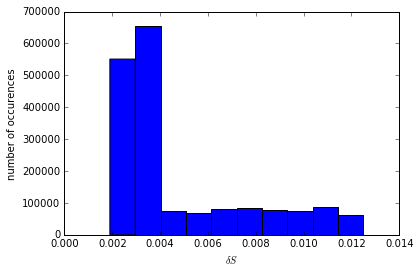

In [16]:
dS = sal_abs-sal_ref
plt.hist(dS.flatten())
plt.xlabel('$\delta S$')
plt.ylabel('number of occurences')

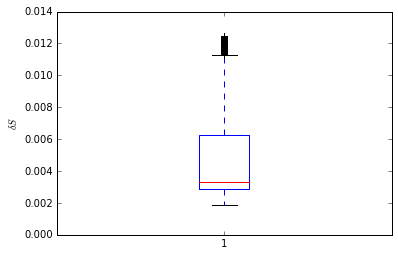

In [17]:
plt.boxplot(dS.flatten())
plt.ylabel('$\delta S$')

This is probably not very significant but we might as well convert the files to absolute salinity instead of reference salinity.

Or is it easier to just quote we used $\delta S = 0$?

Ok, now use my module to test conservatice temperature.

In [18]:
import gsw_calls

In [20]:
CT = gsw_calls.call_CT_from_PT(sal_abs, temp_pot)

(array([ 437682.,  173364.,   94419.,   94391.,  119058.,  180647.,
         302866.,  279873.,  111758.,   15542.]),
 array([ 0.00708202,  0.01536348,  0.02364494,  0.03192639,  0.04020785,
         0.04848931,  0.05677077,  0.06505223,  0.07333369,  0.08161515,
         0.08989661]),
 <a list of 10 Patch objects>)

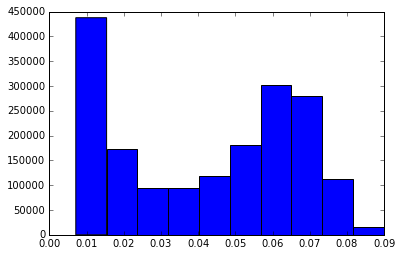

In [28]:
diff=CT-temp_pot
plt.hist(diff.flatten())

Looks like the differences aren't super big for boundary.